<a href="https://colab.research.google.com/github/AleemRahil/GAMs_for_Pricing_Optimization_Strategy/blob/main/GAMs_for_Pricing_Optimization_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PYTHON GAM PRICE OPTIMIZATION

## PART 1: EXPECTILE GAM PRIMER

### Showcases the use of Expectile GAM (Primer for Price Optimization)

In [2]:
pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 5.6 MB/s eta 0:00:00


In [13]:
# prompt: import numpy, pandas, plt pygam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import s, ExpectileGAM



In [134]:
# Data Generation
np.random.seed(0)
n = 10000
price = np.sort(np.random.exponential(scale=100, size =n))
quantity = 1000 - 5*price + np.random.normal(loc=0, scale=50, size=n)
quantity = quantity.clip(min=0)

In [135]:
# Add Outliers
n_outliers = 10
outlier_prices = np.random.uniform(5, 50, n_outliers)
outlier_quantity = 1100 + np.random.normal(loc=0, scale=50, size=n_outliers)
price = np.concatenate([price, outlier_prices])
quantity = np.concatenate([quantity, outlier_quantity])

In [136]:
# Add Outliers
n_outliers = 10
outlier_prices = np.random.uniform(51, 100, n_outliers)
outlier_quantity = 900 + np.random.normal(loc=0, scale=50, size=n_outliers)
price = np.concatenate([price, outlier_prices])
quantity = np.concatenate([quantity, outlier_quantity])

In [137]:
# Create a list of products
products = ["Standard Case | iPhone 15 Pro Max", "Premium Case | iPhone 15 Pro Max", "Standard Case | iPhone 15 Pro", "Premium Case | iPhone 15 Pro"]

# Create a list of events
events = ["No Promo", "Black Friday", "New iPhone", "Christmas"]

In [138]:
import random


In [139]:
df = pd.DataFrame({
    'price': price,
    'quantity_sold': quantity.astype(int)
})


In [140]:
df

,price,quantity_sold
0,0.007245,963
1,0.007370,1028
2,0.015039,978
3,0.025387,994
4,0.030658,883
...,...,...
10015,87.773496,906
10016,53.569882,912
10017,83.376840,813
10018,86.313284,875


In [141]:
df['product'] = pd.DataFrame(random.choices(products, k=10020))
df['event'] = pd.DataFrame(random.choices(events, k=10020))

In [142]:
# Filer out prices less than 5
df = df[df['price'] >= 5]

In [143]:
df

,price,quantity_sold,product,event
513,5.038587,1028,Standard Case | iPhone 15 Pro Max,No Promo
514,5.047327,1020,Standard Case | iPhone 15 Pro,Black Friday
515,5.054122,922,Standard Case | iPhone 15 Pro,New iPhone
516,5.057938,986,Standard Case | iPhone 15 Pro,No Promo
517,5.060821,962,Standard Case | iPhone 15 Pro Max,Christmas
...,...,...,...,...
10015,87.773496,906,Premium Case | iPhone 15 Pro Max,Black Friday
10016,53.569882,912,Premium Case | iPhone 15 Pro,Christmas
10017,83.376840,813,Premium Case | iPhone 15 Pro,Black Friday
10018,86.313284,875,Premium Case | iPhone 15 Pro Max,No Promo


In [144]:
# prompt: save df to a csv file in the path data/price_optimisation.csv

df.to_csv('data/price_optimisation.csv', index=False)


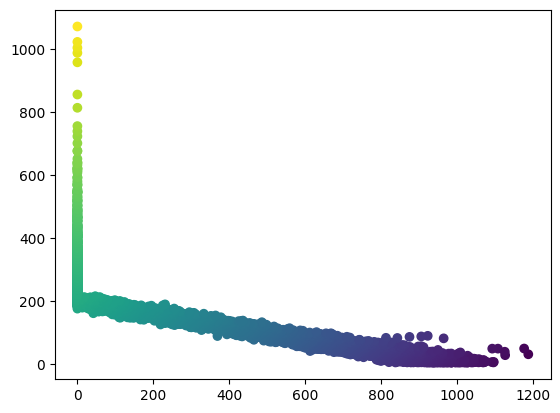

In [145]:
# @title Price and Quantity Spread vs Mean

import matplotlib.pyplot as plt
_ = plt.scatter(df['quantity_sold'], df['price'], c=df['price'] - df['quantity_sold'])

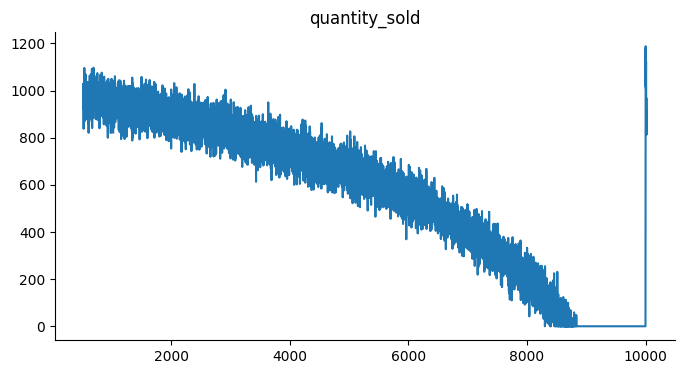

In [146]:
# @title Quantity

from matplotlib import pyplot as plt
df['quantity_sold'].plot(kind='line', figsize=(8, 4), title='quantity_sold')
plt.gca().spines[['top', 'right']].set_visible(False)

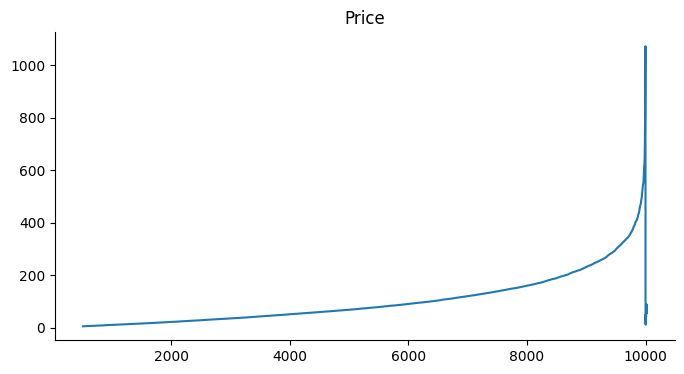

In [147]:
# @title Price

from matplotlib import pyplot as plt
df['price'].plot(kind='line', figsize=(8, 4), title='Price')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: ylabel='Frequency'>

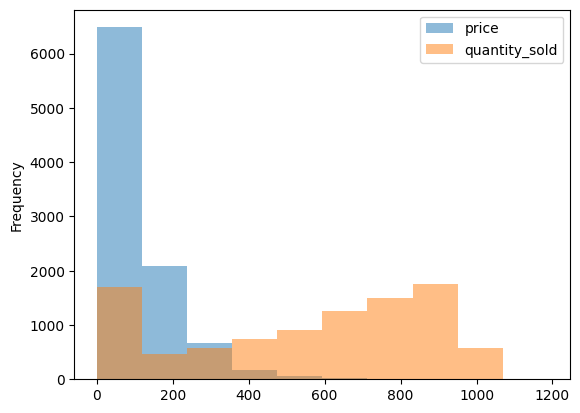

In [148]:
# @title Distribution of Price vs Quantity

df.plot.hist(column=['price', 'quantity_sold'], alpha=0.5)

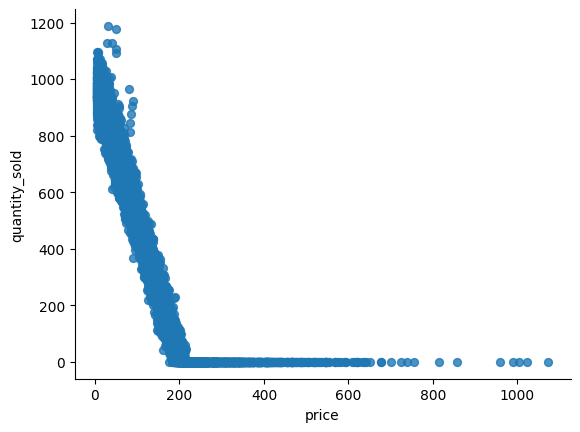

In [149]:
# @title Price vs Quantity

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='price', y='quantity_sold', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

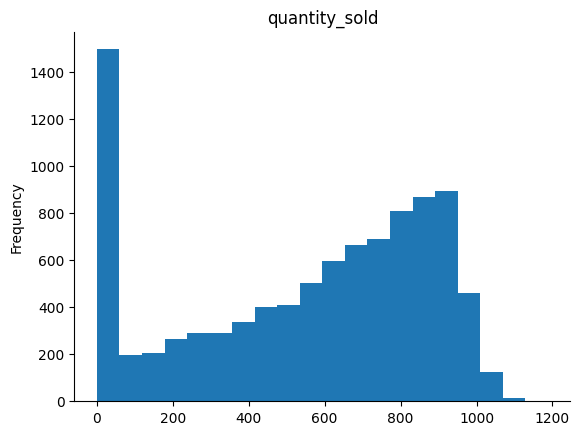

In [150]:
# @title Quantity

from matplotlib import pyplot as plt
df['quantity_sold'].plot(kind='hist', bins=20, title='quantity_sold')
plt.gca().spines[['top', 'right',]].set_visible(False)

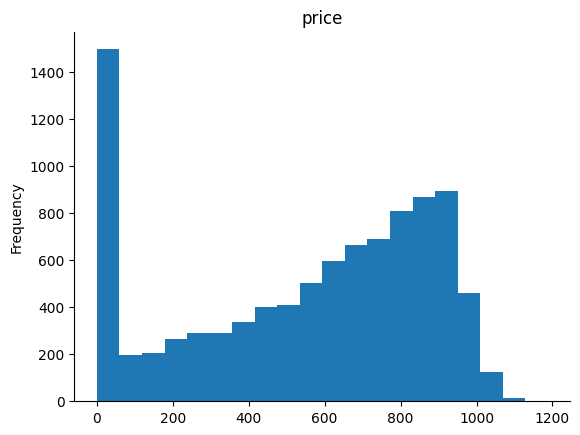

In [151]:
# @title Price

from matplotlib import pyplot as plt
df['quantity_sold'].plot(kind='hist', bins=20, title='price')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Modeling

In [152]:
# Reshape Data
X = df[['price']]
y = df['quantity_sold']

# Quantile GAMs
quantiles = [0.025, 0.5, 0.975]
gam_results = {}

for q in quantiles:
  gam = ExpectileGAM(s(0), expectile=q)
  gam. fit(X,y)
  gam_results[q] = gam

In [153]:
gam_results

{0.025: ExpectileGAM(callbacks=[Deviance(), Diffs()], expectile=0.025, 
    fit_intercept=True, max_iter=100, scale=None, 
    terms=s(0) + intercept, tol=0.0001, verbose=False),
 0.5: ExpectileGAM(callbacks=[Deviance(), Diffs()], expectile=0.5, 
    fit_intercept=True, max_iter=100, scale=None, 
    terms=s(0) + intercept, tol=0.0001, verbose=False),
 0.975: ExpectileGAM(callbacks=[Deviance(), Diffs()], expectile=0.975, 
    fit_intercept=True, max_iter=100, scale=None, 
    terms=s(0) + intercept, tol=0.0001, verbose=False)}

# Visualization

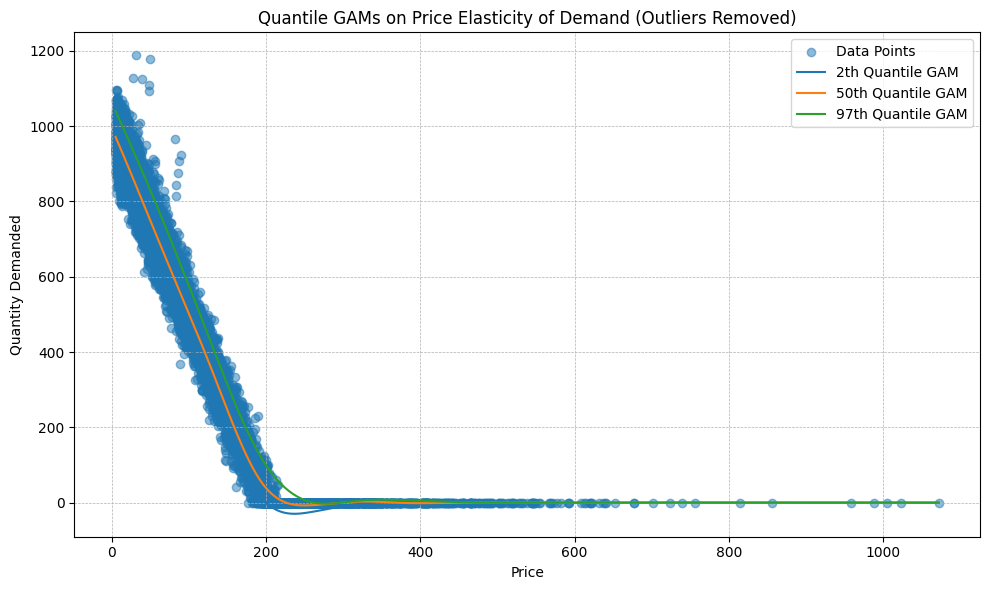

In [154]:
# Scatter Plot
plt.figure(figsize=(10,6))
plt.scatter(df['price'], df['quantity_sold'], alpha=0.5, label='Data Points')

# Plot Quantile GAMs
XX = np.linspace(df['price'].min(), df['price'].max(), 1000).reshape(-1,1)
for q, gam in gam_results.items():
  plt.plot(XX, gam.predict(XX), label=f'{int(q*100)}th Quantile GAM')

# Add titles and labels
plt.xlabel('Price')
plt.ylabel('Quantity Demanded')
plt.title('Quantile GAMs on Price Elasticity of Demand (Outliers Removed)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Price Optimization
## PART 2: EXPECTILE GAM PRICE OPTIMIZATION

In [155]:
pip install pytimetk

In [156]:
# Data Analysis and Modeling
import statsmodels.api as sm
from pygam import GAM, ExpectileGAM, s, l, f
from sklearn.preprocessing import LabelEncoder

# Visualisation
import plotly.express as px
from plotnine import *
import pytimetk as tk
import textwrap

In [157]:
# Load Data
data = pd.read_csv('/content/data/price_optimisation.csv')

In [158]:
data

,price,quantity_sold,product,event
0,5.038587,1028,Standard Case | iPhone 15 Pro Max,No Promo
1,5.047327,1020,Standard Case | iPhone 15 Pro,Black Friday
2,5.054122,922,Standard Case | iPhone 15 Pro,New iPhone
3,5.057938,986,Standard Case | iPhone 15 Pro,No Promo
4,5.060821,962,Standard Case | iPhone 15 Pro Max,Christmas
...,...,...,...,...
9502,87.773496,906,Premium Case | iPhone 15 Pro Max,Black Friday
9503,53.569882,912,Premium Case | iPhone 15 Pro,Christmas
9504,83.376840,813,Premium Case | iPhone 15 Pro,Black Friday
9505,86.313284,875,Premium Case | iPhone 15 Pro Max,No Promo


In [159]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,9507.0,NaN,NaN,NaN,104.194717,99.954664,5.038587,33.305507,73.266989,143.066927,1072.227872
quantity_sold,9507.0,NaN,NaN,NaN,549.66593,327.833315,0.0,281.0,630.0,830.0,1188.0
product,9507,4,Premium Case | iPhone 15 Pro Max,2439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event,9507,4,Christmas,2425,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.0 Data Preparation

In [160]:
data['is_event'] = (data['event'] != "No Promo").astype(int).astype(str)

In [161]:
data['revenue'] = data['price'] * data['quantity_sold']

In [162]:
data

,price,quantity_sold,product,event,is_event,revenue
0,5.038587,1028,Standard Case | iPhone 15 Pro Max,No Promo,0,5179.667347
1,5.047327,1020,Standard Case | iPhone 15 Pro,Black Friday,1,5148.273308
2,5.054122,922,Standard Case | iPhone 15 Pro,New iPhone,1,4659.900336
3,5.057938,986,Standard Case | iPhone 15 Pro,No Promo,0,4987.127322
4,5.060821,962,Standard Case | iPhone 15 Pro Max,Christmas,1,4868.509796
...,...,...,...,...,...,...
9502,87.773496,906,Premium Case | iPhone 15 Pro Max,Black Friday,1,79522.787188
9503,53.569882,912,Premium Case | iPhone 15 Pro,Christmas,1,48855.731953
9504,83.376840,813,Premium Case | iPhone 15 Pro,Black Friday,1,67785.370528
9505,86.313284,875,Premium Case | iPhone 15 Pro Max,No Promo,0,75524.123271


### EDA

#### Trends: Price vs Quantity Sold

In [163]:
fig = px.scatter(
    data,
    x='price',
    y='quantity_sold',
    color = 'product',
    opacity=0.6,
    trendline = 'lowess',
    trendline_color_override='blue',
    template='none',
    title='Product Sales: Price vs Quantity Analysis',
    width=800,
    height=600
).update_traces(
    marker=dict(size=7),
    hoverlabel=dict(font=dict(size=10))
).update_layout(
    legend_title_text = 'Product',
    title_font=dict(size=16),
    legend_font=dict(size=10)
).update_xaxes(
    title_text='Price',
    title_font=dict(size=10),
    tickfont=dict(size=10)
).update_yaxes(
    title_text='Quantity Sold',
    title_font=dict(size=10),
    tickfont=dict(size=10)
)

In [164]:
fig

#### EVENT ANALYSIS (OUTLIERS)

In [165]:
# Scatter Plot
fig = px.scatter(
    data,
    x='price',
    y='quantity_sold',
    color = 'event',
    facet_col = 'product',
    facet_col_wrap=2,
    facet_col_spacing=0.1,
    facet_row_spacing=0.1,
    opacity=0.6,
    trendline = 'lowess',
    trendline_color_override='blue',
    template='none',
    title='Product Sales: Event Analysis',
    width=800,
    height=700
).update_traces(
    marker=dict(size=7),
    hoverlabel=dict(font=dict(size=10))
).update_layout(
    legend_title_text = 'Product',
    title_font=dict(size=16),
    legend_font=dict(size=10)
).update_xaxes(
    title_text='Price',
    title_font=dict(size=10),
    tickfont=dict(size=10)
).update_yaxes(
    title_text='Quantity Sold',
    title_font=dict(size=10),
    tickfont=dict(size=10)
)

for annotation in fig['layout']['annotations']:
  annotation['font'] = dict(size=10)

fig.for_each_xaxis(lambda axis: axis.update(showticklabels=True))
fig.for_each_yaxis(lambda axis: axis.update(showticklabels=True))

In [166]:
fig

#### Modeling Event Impact

In [195]:
df_encoded = data.copy()
df_encoded = pd.get_dummies(df_encoded, columns=['event', 'product'], drop_first=False)

In [196]:
colnames_event = df_encoded.columns[df_encoded.columns.str.startswith('event')].tolist()

In [197]:
df_encoded[colnames_event] = df_encoded[colnames_event].astype(int)

In [198]:
colnames_product = df_encoded.columns[df_encoded.columns.str.startswith('product')].tolist()

In [199]:
df_encoded[colnames_product] = df_encoded[colnames_product].astype(int)

In [200]:
df_encoded

,price,quantity_sold,is_event,revenue,event_Black Friday,event_Christmas,event_New iPhone,event_No Promo,product_Premium Case | iPhone 15 Pro,product_Premium Case | iPhone 15 Pro Max,product_Standard Case | iPhone 15 Pro,product_Standard Case | iPhone 15 Pro Max
0,5.038587,1028,0,5179.667347,0,0,0,1,0,0,0,1
1,5.047327,1020,1,5148.273308,1,0,0,0,0,0,1,0
2,5.054122,922,1,4659.900336,0,0,1,0,0,0,1,0
3,5.057938,986,0,4987.127322,0,0,0,1,0,0,1,0
4,5.060821,962,1,4868.509796,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9502,87.773496,906,1,79522.787188,1,0,0,0,0,1,0,0
9503,53.569882,912,1,48855.731953,0,1,0,0,1,0,0,0
9504,83.376840,813,1,67785.370528,1,0,0,0,1,0,0,0
9505,86.313284,875,0,75524.123271,0,0,0,1,0,1,0,0


In [201]:
X = df_encoded[['price'] + colnames_event + colnames_product]

In [202]:
X = sm.add_constant(X) # Adds a constant to the model (intercept)

In [203]:
y = df_encoded['quantity_sold']

In [204]:
model = sm.OLS(y, X).fit()

In [205]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          quantity_sold   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     4656.
Date:                Thu, 29 Feb 2024   Prob (F-statistic):               0.00
Time:                        03:51:13   Log-Likelihood:                -61482.
No. Observations:                9507   AIC:                         1.230e+05
Df Residuals:                    9499   BIC:                         1.230e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                       566.8840      1.539    368.248      0.000     563.866     569.902
price                                        -2.8854      0.016   -180.399      0.000      -2.917      -2.854
event_Black Friday                          138.7517      2.798     49.587      0.000     133.267     144.237
event_Christmas                             140.5469      2.778     50.599      0.000     135.102     145.992
event_New iPhone                            142.4618      2.802     50.852      0.000     136.970     147.953
event_No Promo                              145.1237      2.803     51.779      0.000     139.630     150.618
product_Premium Case | iPhone 15 Pro        144.8039      2.774     52.200      0.000     139.366     150.242
product_Premium Case | iPhone 15 Pro Max    138.8089      2.769     50.122      0.000     133.380     144.238
product_Standard Case | iPhone 15 Pro       142.1900      2.812     50.559      0.000     136.677     147.703
product_Standard Case | iPhone 15 Pro Max   141.0812      2.826     49.925      0.000     135.542     146.621
==============================================================================
Omnibus:                     5900.469   Durbin-Watson:                   0.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           225120.873
Skew:                           2.400   Prob(JB):                         0.00
Kurtosis:                      26.351   Cond. No.                     1.08e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.69e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [206]:
model.params

const                                        566.883976
price                                         -2.885392
event_Black Friday                           138.751660
event_Christmas                              140.546888
event_New iPhone                             142.461761
event_No Promo                               145.123667
product_Premium Case | iPhone 15 Pro         144.803917
product_Premium Case | iPhone 15 Pro Max     138.808865
product_Standard Case | iPhone 15 Pro        142.189956
product_Standard Case | iPhone 15 Pro Max    141.081238
dtype: float64

In [207]:
params_df = pd.DataFrame(model.params).T

In [208]:
params_df

,const,price,event_Black Friday,event_Christmas,event_New iPhone,event_No Promo,product_Premium Case | iPhone 15 Pro,product_Premium Case | iPhone 15 Pro Max,product_Standard Case | iPhone 15 Pro,product_Standard Case | iPhone 15 Pro Max
0,566.883976,-2.885392,138.75166,140.546888,142.461761,145.123667,144.803917,138.808865,142.189956,141.081238


In [209]:
np.log((params_df['event_Black Friday'] + params_df['const']) / (params_df['event_No Promo'] + params_df['const']))

0   -0.00899
dtype: float64

#### General Price Optimization: GAMs

##### PROBLEM: Prices are not Linear
##### SOLUTION: Use GAMs (Generalized Additive Models)
##### NOTES:
#####       - GAMs are like Linear Regression, but allow for non-linear relationships
#####       - NOT as useful for incorporating events (see next section)




In [237]:
# Keep the entire data as filtered
data_filtered = data.query('event == "No Promo"')

In [238]:
data_filtered

,price,quantity_sold,product,event,is_event,revenue
0,5.038587,1028,Standard Case | iPhone 15 Pro Max,No Promo,0,5179.667347
3,5.057938,986,Standard Case | iPhone 15 Pro,No Promo,0,4987.127322
13,5.182544,965,Standard Case | iPhone 15 Pro,No Promo,0,5001.155284
14,5.185439,995,Standard Case | iPhone 15 Pro Max,No Promo,0,5159.511739
15,5.207447,930,Premium Case | iPhone 15 Pro Max,No Promo,0,4842.926062
...,...,...,...,...,...,...
9496,39.163684,1126,Premium Case | iPhone 15 Pro Max,No Promo,0,44098.308455
9497,56.744966,906,Premium Case | iPhone 15 Pro Max,No Promo,0,51410.939331
9498,89.681184,923,Standard Case | iPhone 15 Pro,No Promo,0,82775.733222
9501,82.877074,843,Standard Case | iPhone 15 Pro Max,No Promo,0,69865.373619


In [239]:
# Create a list of unique Products
unique_products = data_filtered['product'].unique()

In [242]:
len(unique_products)

4

In [244]:
# Create an empty dataframe to store the concatenated results
all_gam_results = pd.DataFrame()

In [245]:
# Loop through each product
for product in unique_products:
  # Filter data for the current product
  product_data = data_filtered[data_filtered['product'] == product]

  X = product_data[['price']]
  y = product_data['quantity_sold']

  quantiles = [0.025, 0.5, 0.975]
  gam_results = {}

  # Fit the GAM model for the filtered data
  for q in quantiles:
    gam = ExpectileGAM(s(0), expectile=q)
    gam.fit(X, y)
    gam_results[f"pred_{q}"] = gam.predict(X)

  # Store the results in a dataframe with index that matches the original data
  predictions_gam = pd.DataFrame(gam_results).set_index(X.index)

  # Concatenate the results column-wise with the original data
  predictions_gam_df = pd.concat([product_data[['price', 'product', 'quantity_sold']], predictions_gam], axis =1)

  # Concatenate the results row-wise with the original data
  all_gam_results = pd.concat([all_gam_results, predictions_gam_df], axis =0)

In [246]:
all_gam_results

,price,product,quantity_sold,pred_0.025,pred_0.5,pred_0.975
0,5.038587,Standard Case | iPhone 15 Pro Max,1028,892.806991,958.106929,1029.977649
14,5.185439,Standard Case | iPhone 15 Pro Max,995,892.102871,957.455513,1029.336590
19,5.236021,Standard Case | iPhone 15 Pro Max,928,891.860335,957.231068,1029.115753
69,5.720597,Standard Case | iPhone 15 Pro Max,925,889.536706,955.079152,1026.999405
75,5.769261,Standard Case | iPhone 15 Pro Max,955,889.303337,954.862867,1026.786793
...,...,...,...,...,...,...
9395,464.027952,Premium Case | iPhone 15 Pro,0,-7.623260,0.487067,8.453876
9422,494.585445,Premium Case | iPhone 15 Pro,0,-0.345879,-0.364879,9.944563
9428,506.898492,Premium Case | iPhone 15 Pro,0,2.176161,-0.656977,10.439308
9485,1023.250682,Premium Case | iPhone 15 Pro,0,0.289488,-0.065984,2.978401


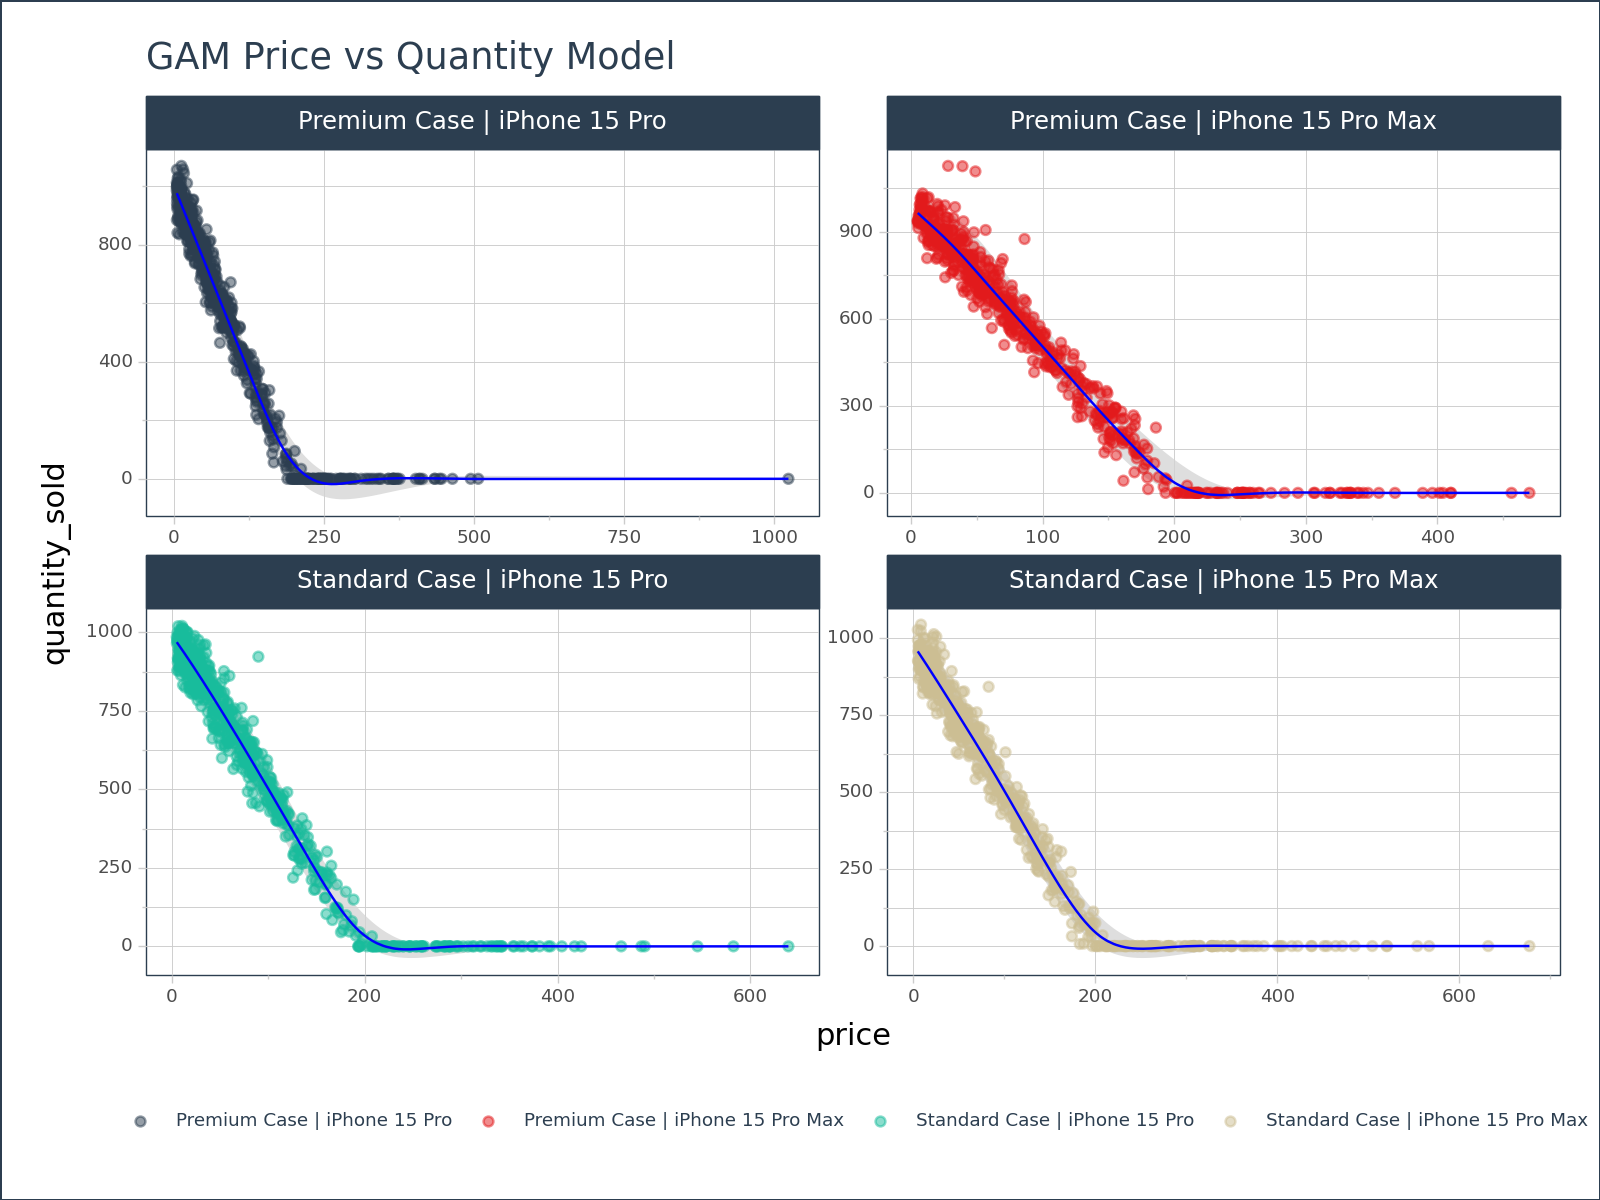

<Figure Size: (800 x 600)>

In [247]:
# Visualize the GAM Price Model Results
ggplot(
    data = all_gam_results,
    mapping = aes(x='price', y='quantity_sold', color='product', group = 'product')
  ) + \
  geom_ribbon(aes(ymax = 'pred_0.975', ymin = 'pred_0.025'), fill = '#d3d3d3', color='#FF000000', alpha=0.75, show_legend = False) + \
  geom_point(alpha=0.5) + \
  geom_line(aes(y='pred_0.5'), color = 'blue') + \
  facet_wrap('product', scales='free') + \
  labs(title = 'GAM Price vs Quantity Model') + \
  scale_color_manual(values = list(tk.palette_timetk().values())) + \
  tk.theme_timetk(width = 800, height = 600)

In [248]:
# Optimiza Price for Predicted Daily Revenue

for col in all_gam_results.columns:
  if col.startswith('pred'):
    all_gam_results['revenue_' + col] = all_gam_results['price']*all_gam_results[col]

all_gam_results['revenue_actual'] = all_gam_results['price']*all_gam_results['quantity_sold']

In [249]:
all_gam_results

,price,product,quantity_sold,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975,revenue_actual
0,5.038587,Standard Case | iPhone 15 Pro Max,1028,892.806991,958.106929,1029.977649,4498.485620,4827.505034,5189.631902,5179.667347
14,5.185439,Standard Case | iPhone 15 Pro Max,995,892.102871,957.455513,1029.336590,4625.944962,4964.827095,5337.562032,5159.511739
19,5.236021,Standard Case | iPhone 15 Pro Max,928,891.860335,957.231068,1029.115753,4669.799794,5012.082353,5388.472098,4859.027854
69,5.720597,Standard Case | iPhone 15 Pro Max,925,889.536706,955.079152,1026.999405,5088.680649,5463.622538,5875.049292,5291.551846
75,5.769261,Standard Case | iPhone 15 Pro Max,955,889.303337,954.862867,1026.786793,5130.622934,5508.852963,5923.800851,5509.644119
...,...,...,...,...,...,...,...,...,...,...
9395,464.027952,Premium Case | iPhone 15 Pro,0,-7.623260,0.487067,8.453876,-3537.405548,226.012686,3922.834724,0.000000
9422,494.585445,Premium Case | iPhone 15 Pro,0,-0.345879,-0.364879,9.944563,-171.066828,-180.463993,4918.436358,0.000000
9428,506.898492,Premium Case | iPhone 15 Pro,0,2.176161,-0.656977,10.439308,1103.092811,-333.020611,5291.669247,0.000000
9485,1023.250682,Premium Case | iPhone 15 Pro,0,0.289488,-0.065984,2.978401,296.218568,-67.518366,3047.650781,0.000000


In [250]:
best_50 = all_gam_results \
  .groupby('product') \
  .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1)).reset_index(level=0, drop=True)

In [251]:
best_975 = all_gam_results \
  .groupby('product') \
  .apply(lambda x: x[x['revenue_pred_0.975'] == x['revenue_pred_0.975'].max()].head(1)).reset_index(level=0, drop=True)

In [252]:
best_025 = all_gam_results \
  .groupby('product') \
  .apply(lambda x: x[x['revenue_pred_0.025'] == x['revenue_pred_0.025'].max()].head(1)).reset_index(level=0, drop=True)

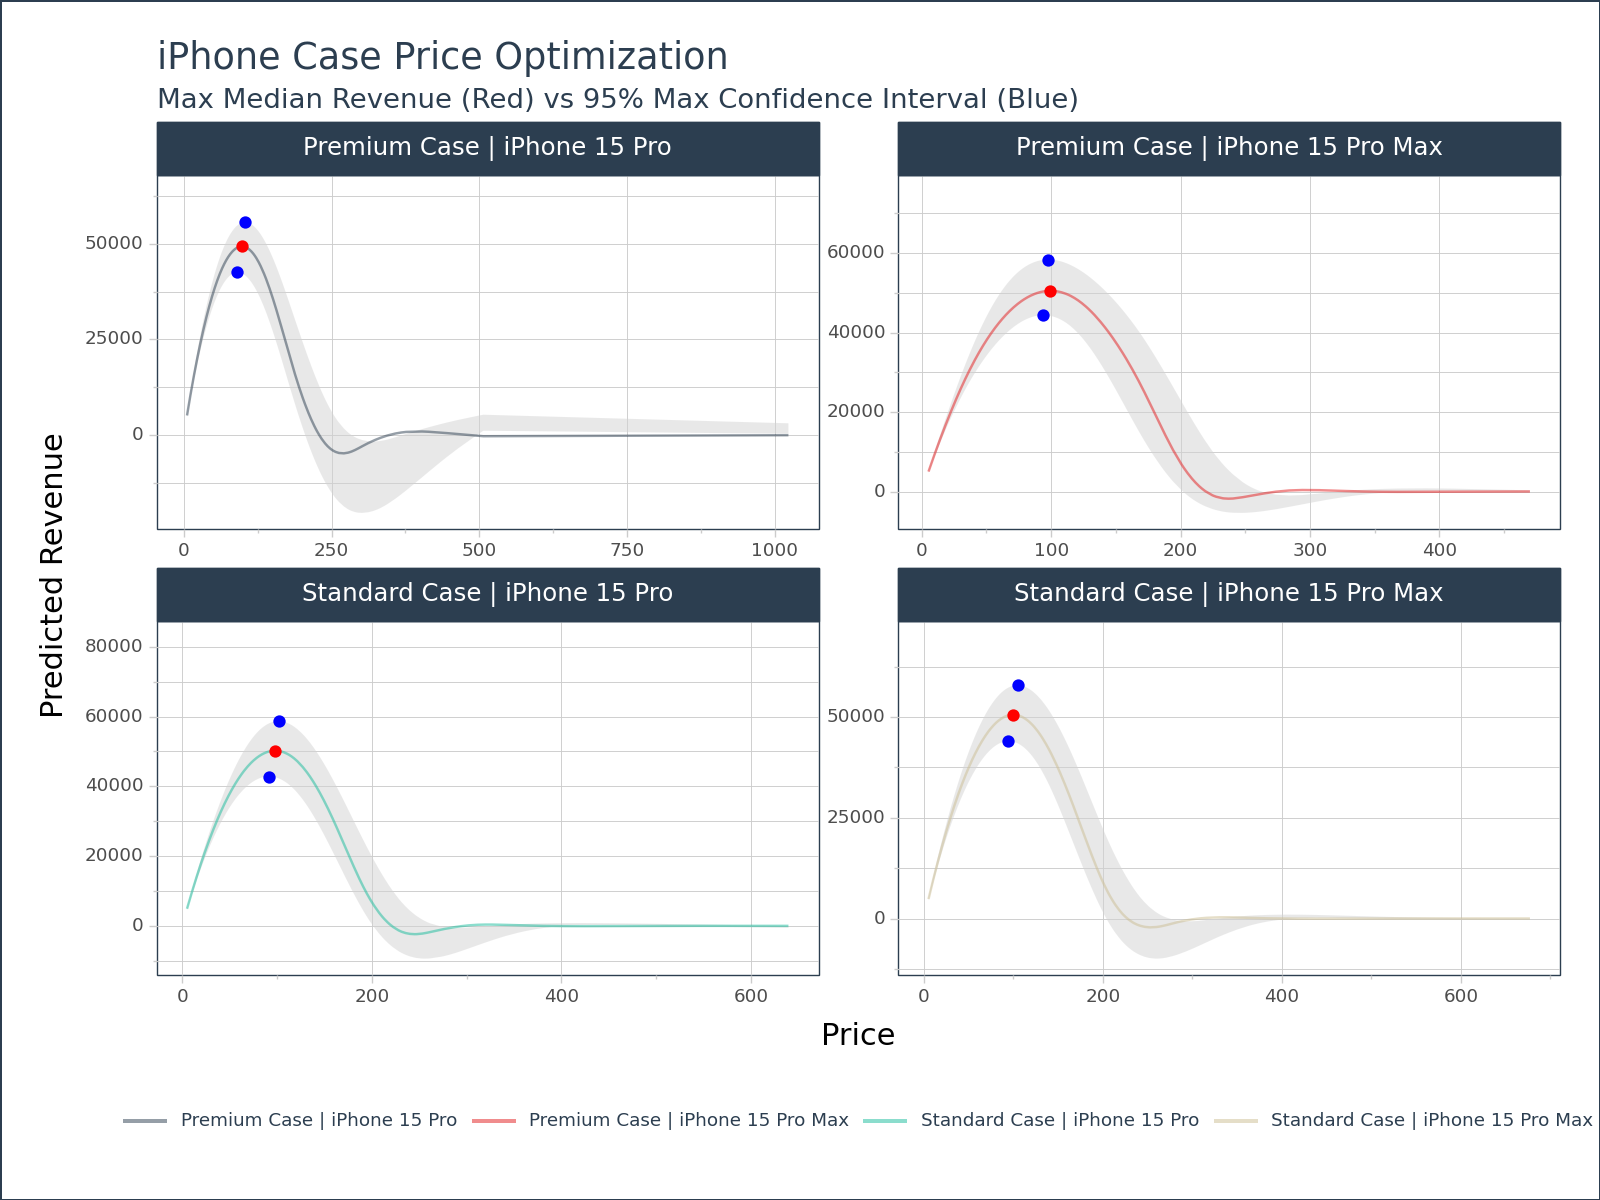

<Figure Size: (800 x 600)>

In [253]:
# Visualize the GAM Revenue Optimization Results

(
  ggplot(
      data = all_gam_results,
      mapping = aes(x='price', y='revenue_pred_0.5', color='product', group = 'product')
  ) + \
    geom_ribbon(aes(ymax = 'revenue_pred_0.975', ymin = 'revenue_pred_0.025'), fill = '#d3d3d3', color='#FF000000', alpha=0.5, show_legend = False) + \
    # Uncomment to add actual revenue points
    geom_point(aes(ymax = 'revenue_actual'),  color='#FF000000', alpha=0.5) + \
    geom_line(aes(y='revenue_pred_0.5'), alpha=0.5) + \
    geom_point(data=best_50, color='red') + \
    geom_point(data=best_975, mapping = aes(y='revenue_pred_0.975') , color='blue') + \
    geom_point(data=best_025, mapping = aes(y='revenue_pred_0.025') , color='blue') + \
    # geom_line(aes(y='pred_0.5'), color = 'blue') + \
    facet_wrap('product', scales='free') + \
    labs(
        title = 'iPhone Case Price Optimization',
        subtitle = 'Max Median Revenue (Red) vs 95% Max Confidence Interval (Blue)',
        x='Price',
        y='Predicted Revenue'
        ) + \
    scale_color_manual(values = list(tk.palette_timetk().values())) + \
    tk.theme_timetk(width = 800, height = 600)
)

In [254]:
best_50[['product', 'price', 'revenue_pred_0.5', 'revenue_pred_0.025', 'revenue_pred_0.975']]

,product,price,revenue_pred_0.5,revenue_pred_0.025,revenue_pred_0.975
5801,Premium Case | iPhone 15 Pro,98.134033,49322.170605,42266.560931,55501.594892
5843,Premium Case | iPhone 15 Pro Max,98.973542,50489.468273,44209.473392,58355.097006
5800,Standard Case | iPhone 15 Pro,98.011029,50195.634473,42584.531788,58581.300650
5859,Standard Case | iPhone 15 Pro Max,99.650294,50574.470629,43886.816667,57759.916711


# BUSINESS INSIGHTS

###### 1. The GAMs show that the optimal price is at the ends of the price range for: Premium Case | iPhone 15 Pro Max Standard Case | iPhone 15 Pro Max
###### This suggests that the company should consider a price increase for these models

###### 2. The GAMS show that the optimal price is in the middle of the price range for Premium Case | iPhone 15 Pro and Standard Case | iPhone 15 Pro
###### This suggest that the company should consider a price that is close to the red dots for these products

# MODELING GAMS WITH EVENTS:

## Essentially the same process as above, but we need to filter out the "No Promo" events

## Gets a little tricky because of limited data points for each event

In [255]:
#Keep the entire data as data_filtered
data_filtered = data.query('event != "No Promo"')


In [256]:
data_filtered

,price,quantity_sold,product,event,is_event,revenue
1,5.047327,1020,Standard Case | iPhone 15 Pro,Black Friday,1,5148.273308
2,5.054122,922,Standard Case | iPhone 15 Pro,New iPhone,1,4659.900336
4,5.060821,962,Standard Case | iPhone 15 Pro Max,Christmas,1,4868.509796
5,5.075814,984,Standard Case | iPhone 15 Pro Max,New iPhone,1,4994.600964
6,5.076685,1029,Premium Case | iPhone 15 Pro Max,Christmas,1,5223.908659
...,...,...,...,...,...,...
9500,55.809201,898,Premium Case | iPhone 15 Pro,Christmas,1,50116.662441
9502,87.773496,906,Premium Case | iPhone 15 Pro Max,Black Friday,1,79522.787188
9503,53.569882,912,Premium Case | iPhone 15 Pro,Christmas,1,48855.731953
9504,83.376840,813,Premium Case | iPhone 15 Pro,Black Friday,1,67785.370528


In [257]:
# Create a list of unique products and events
unique_products = data_filtered['product'].unique()
events_only_gam_results = pd.DataFrame()


In [260]:
# Loop through each product
for product in unique_products:

  #Filter data for the current product and event
  product_event_data = data_filtered[(data_filtered['product'] == product)]

  if len(product_event_data) ==0:
    continue # skip to next iteration if no data for current product-event combination

  X = product_event_data[['price', 'event']]
  y = product_event_data['quantity_sold']

  # NEW: Encode the event columm
  le = LabelEncoder()
  X['event'] = le.fit_transform(X['event'])

  quantiles = [0.025, 0.5, 0.975]

  for q in quantiles:

    #NEW: use f(1) to indicate that the event column is categorical
    gam = GAM(l(0) + f(1))

    gam.fit(X, y)
    gam_results[f"pred_{q}"] = gam.predict(X)

  # Store the results in a dataframe with index that matches the original data
  predictions_gam = pd.DataFrame(gam_results).set_index(X.index)

  # Concatenate the results column-wise with the original data
  predictions_gam_df = pd.concat([product_event_data[['price', 'product', 'event', 'quantity_sold']], predictions_gam], axis =1)

  # Concatenate results row-wise
  events_only_gam_results = pd.concat([events_only_gam_results, predictions_gam_df], axis=0)

In [279]:
events_only_gam_results

,price,product,event,quantity_sold,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975,revenue_actual
1,5.047327,Standard Case | iPhone 15 Pro,Black Friday,1020,821.297409,821.297409,821.297409,826.344736,826.344736,826.344736,NaN
2,5.054122,Standard Case | iPhone 15 Pro,New iPhone,922,814.060725,814.060725,814.060725,819.114846,819.114846,819.114846,NaN
17,5.219870,Standard Case | iPhone 15 Pro,Black Friday,949,820.825429,820.825429,820.825429,826.045300,826.045300,826.045300,NaN
30,5.306868,Standard Case | iPhone 15 Pro,Christmas,1008,817.042973,817.042973,817.042973,822.349841,822.349841,822.349841,NaN
42,5.468470,Standard Case | iPhone 15 Pro,New iPhone,958,812.927306,812.927306,812.927306,818.395776,818.395776,818.395776,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9499,60.709663,Premium Case | iPhone 15 Pro,Christmas,856,676.883744,676.883744,676.883744,737.593407,737.593407,737.593407,NaN
9500,55.809201,Premium Case | iPhone 15 Pro,Christmas,898,691.438546,691.438546,691.438546,747.247746,747.247746,747.247746,NaN
9503,53.569882,Premium Case | iPhone 15 Pro,Christmas,912,698.089521,698.089521,698.089521,751.659402,751.659402,751.659402,NaN
9504,83.376840,Premium Case | iPhone 15 Pro,Black Friday,813,614.498994,614.498994,614.498994,697.875834,697.875834,697.875834,NaN


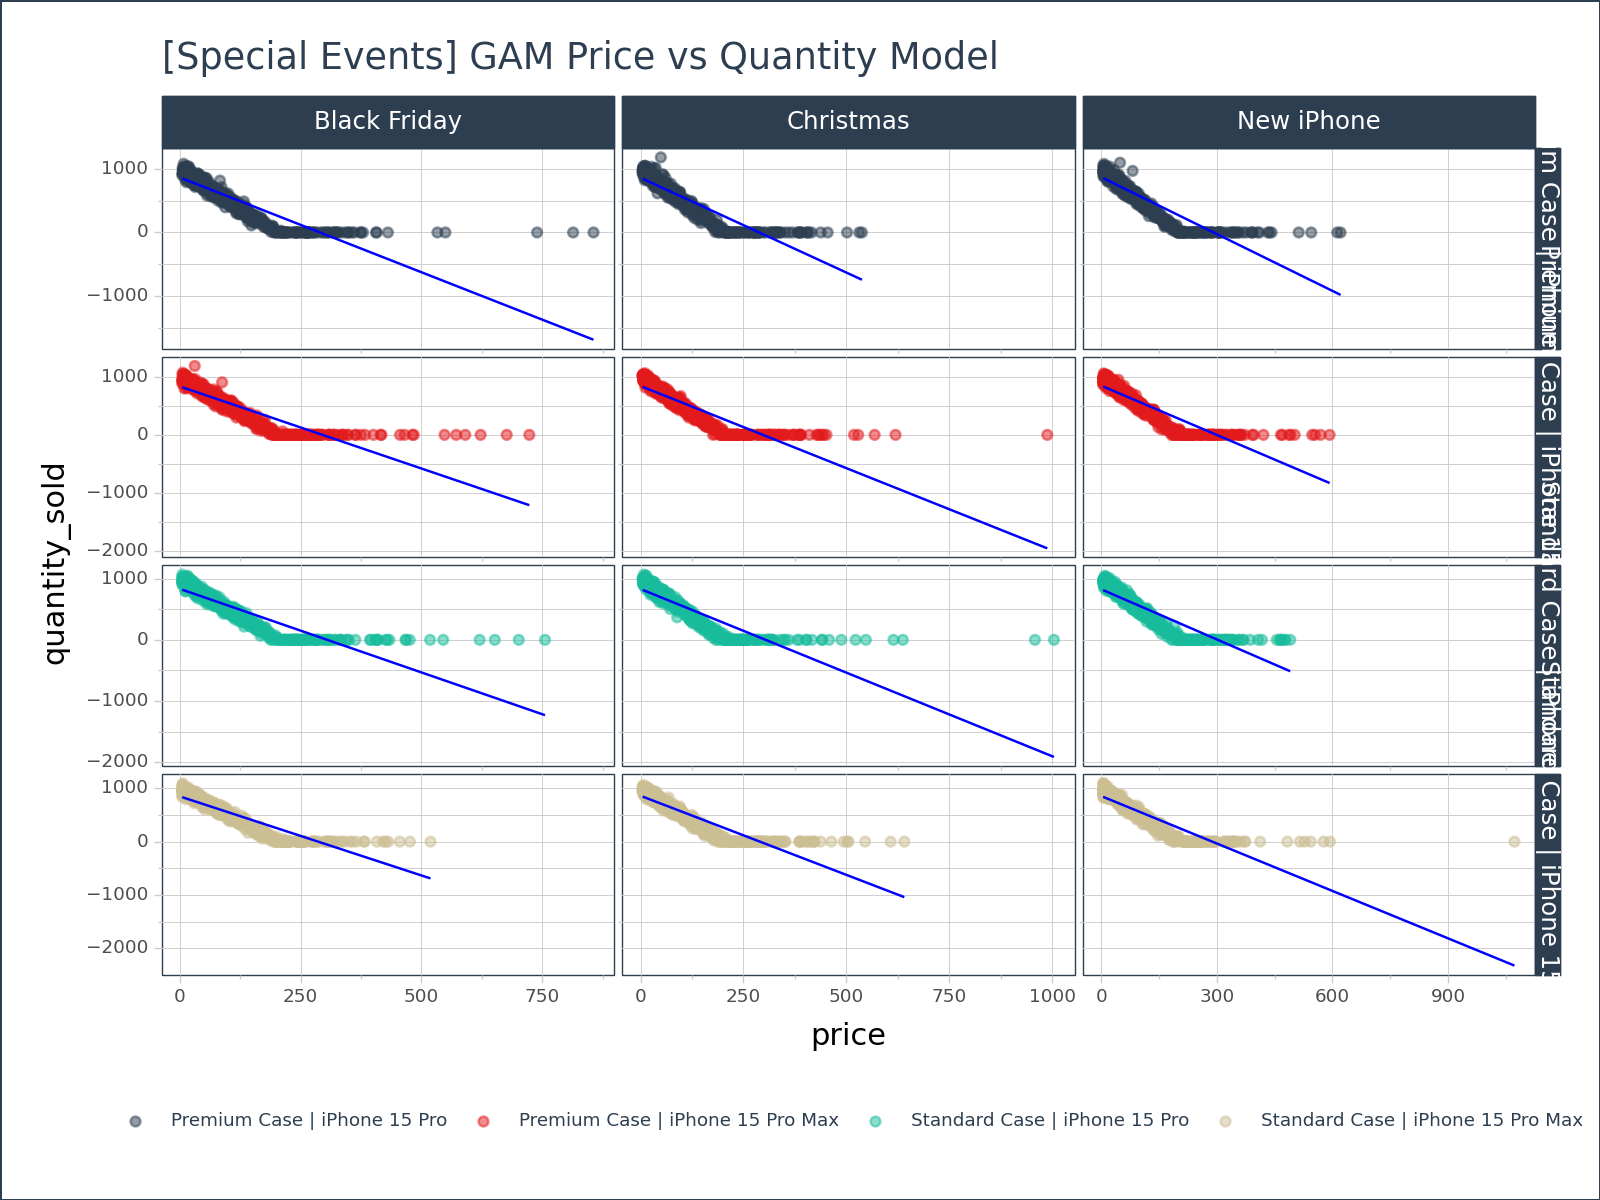

<Figure Size: (800 x 600)>

In [281]:
# Visualize the GAM Price Model Results
ggplot(
    data = events_only_gam_results,
    mapping = aes(x='price', y='quantity_sold', color='product'),
  ) + \
  geom_point(alpha=0.5) + \
  geom_line(aes(y='pred_0.5'), color = 'blue') + \
  facet_grid('product ~ event', scales='free') + \
  labs(title = '[Special Events] GAM Price vs Quantity Model') + \
  scale_color_manual(values = list(tk.palette_timetk().values())) + \
  tk.theme_timetk(width = 800, height = 600)

In [292]:
# Optimiza Price for Predicted Daily Revenue

for col in events_only_gam_results.columns:
  if col.startswith('pred'):
    events_only_gam_results['revenue_' + col] = events_only_gam_results['price'] + events_only_gam_results[col]



In [293]:
events_only_gam_results

,price,product,event,quantity_sold,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975,revenue_actual
1,5.047327,Standard Case | iPhone 15 Pro,Black Friday,1020,821.297409,821.297409,821.297409,826.344736,826.344736,826.344736,NaN
2,5.054122,Standard Case | iPhone 15 Pro,New iPhone,922,814.060725,814.060725,814.060725,819.114846,819.114846,819.114846,NaN
17,5.219870,Standard Case | iPhone 15 Pro,Black Friday,949,820.825429,820.825429,820.825429,826.045300,826.045300,826.045300,NaN
30,5.306868,Standard Case | iPhone 15 Pro,Christmas,1008,817.042973,817.042973,817.042973,822.349841,822.349841,822.349841,NaN
42,5.468470,Standard Case | iPhone 15 Pro,New iPhone,958,812.927306,812.927306,812.927306,818.395776,818.395776,818.395776,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9499,60.709663,Premium Case | iPhone 15 Pro,Christmas,856,676.883744,676.883744,676.883744,737.593407,737.593407,737.593407,NaN
9500,55.809201,Premium Case | iPhone 15 Pro,Christmas,898,691.438546,691.438546,691.438546,747.247746,747.247746,747.247746,NaN
9503,53.569882,Premium Case | iPhone 15 Pro,Christmas,912,698.089521,698.089521,698.089521,751.659402,751.659402,751.659402,NaN
9504,83.376840,Premium Case | iPhone 15 Pro,Black Friday,813,614.498994,614.498994,614.498994,697.875834,697.875834,697.875834,NaN


In [294]:
best_50 = events_only_gam_results \
  .groupby(['product', 'event']) \
  .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1)).reset_index(level=0, drop=True)

In [295]:
best_975 = events_only_gam_results \
  .groupby(['product', 'event']) \
  .apply(lambda x: x[x['revenue_pred_0.975'] == x['revenue_pred_0.975'].max()].head(1)).reset_index(level=0, drop=True)

In [296]:
best_025 = events_only_gam_results \
  .groupby(['product', 'event']) \
  .apply(lambda x: x[x['revenue_pred_0.025'] == x['revenue_pred_0.025'].max()].head(1)).reset_index(level=0, drop=True)

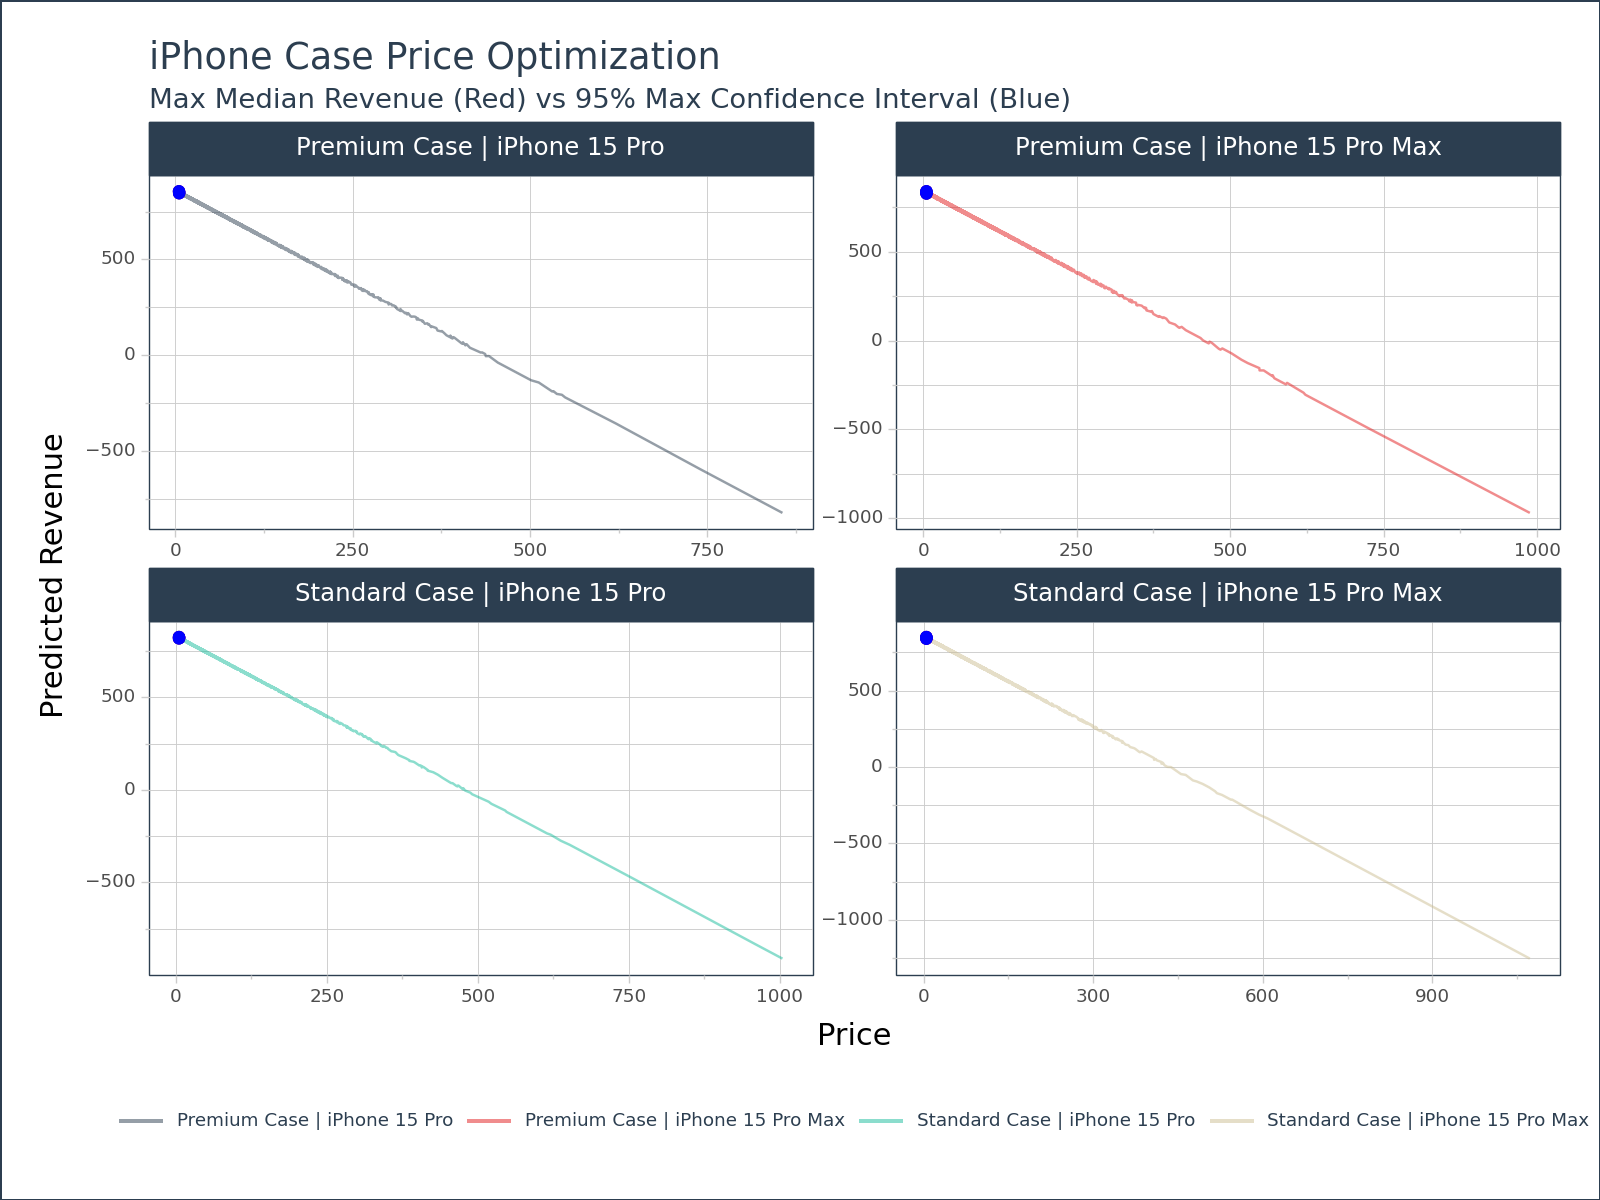

<Figure Size: (800 x 600)>

In [297]:
# Visualize the GAM Revenue Optimization Results

(
  ggplot(
      data = events_only_gam_results,
      mapping = aes(x='price', y='revenue_pred_0.5', color='product', group = 'product')
  ) + \
    geom_ribbon(aes(ymax = 'revenue_pred_0.975', ymin = 'revenue_pred_0.025'), fill = '#d3d3d3', color='#FF000000', alpha=0.5, show_legend = False) + \
    # Uncomment to add actual revenue points
    geom_point(aes(ymax = 'revenue_actual'),  color='#FF000000', alpha=0.5) + \
    geom_line(aes(y='revenue_pred_0.5'), alpha=0.5) + \
    geom_point(data=best_50, color='red') + \
    geom_point(data=best_975, mapping = aes(y='revenue_pred_0.975') , color='blue') + \
    geom_point(data=best_025, mapping = aes(y='revenue_pred_0.025') , color='blue') + \
    # geom_line(aes(y='pred_0.5'), color = 'blue') + \
    facet_wrap('product', scales='free') + \
    labs(
        title = 'iPhone Case Price Optimization',
        subtitle = 'Max Median Revenue (Red) vs 95% Max Confidence Interval (Blue)',
        x='Price',
        y='Predicted Revenue'
        ) + \
    scale_color_manual(values = list(tk.palette_timetk().values())) + \
    tk.theme_timetk(width = 800, height = 600)
)

In [298]:
best_50[['product', 'price', 'revenue_pred_0.5', 'revenue_pred_0.025', 'revenue_pred_0.975']]

,,product,price,revenue_pred_0.5,revenue_pred_0.025,revenue_pred_0.975
event,,,,,,
Black Friday,40,Premium Case | iPhone 15 Pro,5.449759,851.399015,851.399015,851.399015
Christmas,39,Premium Case | iPhone 15 Pro,5.426602,846.505884,846.505884,846.505884
New iPhone,24,Premium Case | iPhone 15 Pro,5.246898,856.415403,856.415403,856.415403
Black Friday,29,Premium Case | iPhone 15 Pro Max,5.277952,826.397102,826.397102,826.397102
Christmas,6,Premium Case | iPhone 15 Pro Max,5.076685,832.696197,832.696197,832.696197
New iPhone,11,Premium Case | iPhone 15 Pro Max,5.159972,838.828712,838.828712,838.828712
Black Friday,1,Standard Case | iPhone 15 Pro,5.047327,826.344736,826.344736,826.344736
Christmas,30,Standard Case | iPhone 15 Pro,5.306868,822.349841,822.349841,822.349841
New iPhone,2,Standard Case | iPhone 15 Pro,5.054122,819.114846,819.114846,819.114846
